In [473]:
import os
from pathlib import Path
import numpy as np

In [474]:
cwd = Path(os.getcwd())
PROJETC_ROOT = cwd.parent
DATA_PATH = PROJETC_ROOT / "data"

# basis = np.load(DATA_PATH / "basis.npz")["matrix"]

In [475]:
# RESULTS_DIR = PROJECT_ROOT / "results" / "pca" / "non-normalized"

## Dataset size

In [476]:
# num_samples = basis.shape[0]
# original_num_features = basis.shape[1]

# print(f"Number of samples: {num_samples}")
# print(f"Number of features: {original_num_features}")

In [477]:
# X_NORM = np.load(DATA_PATH / 'X_norm.npz')['X_norm']
# X = np.load(DATA_PATH / 'X.npz')['X']

## Experiments options

### Gathering results

In [478]:
RESULTS_DIR = PROJETC_ROOT/ "results"

In [479]:
methods = ["PCA", "PaCMAP", "tSNE", "TriMAP", "UMAP"]
methods =[m.lower() for m in methods]

archs = ["CPU", "GPU"]
archs = [a.lower() for a in archs]

dataset_options = ["normalized", "non_normalized", "non-normalized"]

In [480]:
from dataclasses import dataclass
import re
from typing import Optional


@dataclass
class LogMetrics:
    timestamp: Optional[str] = None
    method_details: Optional[str] = None
    explained_variance_first_2: Optional[tuple[float, float]] = None
    total_explained_variance_100_comps: Optional[float] = None
    components_for_90_variance: Optional[int] = None
    wall_time_s: Optional[float] = None
    cpu_time_user_s: Optional[float] = None
    cpu_time_sys_s: Optional[float] = None
    cpu_time_total_s: Optional[float] = None
    gpu_kernel_time_s: Optional[float] = None
    gpu_memory_used_mb: Optional[float] = None
    gpu_memory_total_mb: Optional[float] = None
    gpu_model: Optional[str] = None
    gpu_driver: Optional[str] = None
    points: Optional[int] = None
    original_dims: Optional[int] = None
    pca_dims_saved: Optional[int] = None
    hostname: Optional[str] = None
    # Add other fields if necessary for other log types

def parse_log_metrics(log_content: str) -> LogMetrics:
    data = LogMetrics()
    for line in log_content.splitlines():
        line = line.strip()
        if not line:
            continue

        if data.timestamp is None and line.startswith("["):
            match_header = re.match(r"\[(.*?)\]\s*(.*)", line)
            if match_header:
                data.timestamp = match_header.group(1)
                data.method_details = match_header.group(2)
                continue
        
        m = re.search(r"Wall time: ([\d.]+) s", line)
        if m: data.wall_time_s = float(m.group(1)); continue
        
        m = re.search(r"CPU times: user ([\d.]+) s, sys ([\d.]+) s, total ([\d.]+) s", line)
        if m:
            data.cpu_time_user_s = float(m.group(1))
            data.cpu_time_sys_s = float(m.group(2))
            data.cpu_time_total_s = float(m.group(3))
            continue
        
        m = re.search(r"Explained variance \(first 2\): ([\d.]+)%, ([\d.]+)%", line)
        if m: data.explained_variance_first_2 = (float(m.group(1)), float(m.group(2))); continue
        
        m = re.search(r"Total explained variance \((\d+) comps\): ([\d.]+)%", line)
        if m: data.total_explained_variance_100_comps = float(m.group(2)); continue
            
        m = re.search(r"Components needed for >=90% variance: (\d+)", line)
        if m: data.components_for_90_variance = int(m.group(1)); continue

        m = re.search(r"GPU kernel time: ([\d.]+) s", line)
        if m: data.gpu_kernel_time_s = float(m.group(1)); continue

        m = re.search(r"GPU memory used: ([\d.]+) MB / ([\d.]+) MB", line)
        if m:
            data.gpu_memory_used_mb = float(m.group(1))
            data.gpu_memory_total_mb = float(m.group(2))
            continue

        m = re.search(r"GPU model: (.*?), Driver: (.*)", line)
        if m:
            data.gpu_model = m.group(1).strip()
            data.gpu_driver = m.group(2).strip()
            continue

        m = re.search(r"Points: (\d+), Original dims: (\d+), PCA dims saved: (\d+)", line)
        if m:
            data.points = int(m.group(1))
            data.original_dims = int(m.group(2))
            data.pca_dims_saved = int(m.group(3))
            continue
        
        m = re.search(r"Hostname: (.*)", line)
        if m: data.hostname = m.group(1).strip(); continue
    return data

In [481]:
from typing import List


@dataclass
class ExperimentResult:
    method: str
    architecture: str
    dataset_type: str
    metrics: LogMetrics
    precomputed_pca: str | None
    original_method_arch_string: str

all_experiment_results: List[ExperimentResult] = []


In [482]:
RESULTS_DIR

WindowsPath('c:/Users/basia/Desktop/Semestr_letni_8/LCS/projekt_2/LSC_Dimensionality_Reduction/results')

In [483]:
TEST_DIR_TO_SKIP = "test"

In [484]:
log_metrics_data = []
all_experiment_results = []

def match(parampacmap_substr: str):
    parampacmap_substr = parampacmap_substr.lower()
    for m in methods:
        m_lower = m.lower()
        if m_lower in parampacmap_substr:
            intersection = ''.join([ch for ch in m_lower if ch in m])
            return intersection
    return False

for time_file_path in RESULTS_DIR.rglob("*_time.txt"):
    if TEST_DIR_TO_SKIP in str(time_file_path):
        continue
    if time_file_path.is_file():
        # Store log metrics          
        log_content = time_file_path.read_text(encoding='utf-8')
        log_metrics = parse_log_metrics(log_content)
        log_metrics_data.append(log_metrics)

        # Parse path to extract method, architecture, dataset type, and precomputed PCA
        relative_to_project_root = time_file_path.relative_to(RESULTS_DIR)
        path = os.sep + str(relative_to_project_root)
        path = path[1:] # Remove first slash

        parts_with_os_sep = path.split(os.sep)

        method = None
        normalized = "non_normalized"
        arch = "cpu"
        precomputed_pca = False

        for part in parts_with_os_sep:
            part = part.lower() # just to make sure

            if "_" in part:
                original_part = part
                parts = part.split("_") # Output: ['pacmap', 'cpu']
                for subpart in parts:
                    if "cmlu" in subpart:
                        arch = "gpu"
                    intersection = match(subpart) # paramapcmap & pacmap -> pacmap
                    if subpart in methods:
                        method = subpart
                    elif intersection:
                        method = intersection
                    elif subpart in dataset_options:
                        if subpart == "raw":
                            normalized = "non_normalized"
                        normalized = subpart
                    elif subpart in archs:
                        arch = subpart
                    elif "pca" in subpart:
                        precomputed_pca = True

            if "cmlu" in part:
                arch = "gpu"
            if part in methods:
                method = part
            elif part in dataset_options:
                if part == "raw" or part == "non-normalized":
                    part = "non_normalized"
                normalized = part
            elif part in archs:
                arch = part
            elif "pca" in part:
                precomputed_pca = True

        experiment = ExperimentResult(
                method=method,
                architecture=arch,
                dataset_type=normalized,
                metrics=log_metrics,
                precomputed_pca=precomputed_pca,
                original_method_arch_string=original_part
            )
        all_experiment_results.append(experiment)

In [485]:
import pandas as pd

In [486]:
import pandas as pd

In [487]:
df_metrics = pd.DataFrame([vars(metric) for metric in log_metrics_data])

In [488]:
df_results = pd.DataFrame([vars(res) for res in all_experiment_results])

In [489]:
if all_experiment_results:
    experiment_data_for_df = []
    for exp in all_experiment_results:
        exp_vars = vars(exp).copy()
        # print(exp_vars)

        if 'metrics' in exp_vars:
            metrics_data = exp_vars.pop('metrics')
            metrics_vars = metrics_data.__dict__
            combined_vars = {**exp_vars, **metrics_vars}
        else:
            combined_vars = exp_vars
        experiment_data_for_df.append(combined_vars)
    
    df_experiments = pd.DataFrame(experiment_data_for_df)


else:
    print("'all_experiment_results' is empty.")

df_experiments['wall_time_s'] = pd.to_numeric(df_experiments['wall_time_s'], errors='coerce')

In [490]:
df_experiments["wall_time_s"]

0      1720.77
1      1941.74
2      1867.88
3      1746.97
4      1826.25
5      2294.74
6      2391.95
7      2166.80
8      2186.67
9        11.13
10       12.68
11       11.71
12        1.23
13        0.87
14     2771.53
15     3061.69
16     3648.95
17     2941.83
18     2731.92
19     1569.49
20     1597.14
21      816.92
22      893.91
23      338.95
24      326.99
25       71.42
26    18561.19
27     2298.71
28     1893.86
29     1868.19
30     1464.29
31     1602.06
32       30.72
33       29.40
34       25.60
35       24.27
36       24.37
37       26.96
Name: wall_time_s, dtype: float64

In [491]:
# ...existing code...
# Ensure df_experiments is created and populated correctly first.
# For example, from cell '4ab83867'

if 'df_experiments' in locals() and not df_experiments.empty:
    if 'dataset_type' in df_experiments.columns and 'wall_time_s' in df_experiments.columns:
        
        # Ensure wall_time_s is numeric, coercing errors to NaN
        df_experiments['wall_time_s'] = pd.to_numeric(df_experiments['wall_time_s'], errors='coerce')
        
        # Drop rows where wall_time_s might have become NaN after coercion, or if dataset_type is NaN
        df_cleaned_for_grouping = df_experiments.dropna(subset=['wall_time_s', 'dataset_type'])

        if not df_cleaned_for_grouping.empty:
            # Find the index of the row with the minimum wall_time_s for each dataset_type
            # idxmin() returns the index of the first occurrence of the minimum value in each group.
            idx_min_wall_time_per_group = df_cleaned_for_grouping.groupby('dataset_type')['wall_time_s'].idxmin()

            # Use these indices to select the complete rows for the best experiments in each group
            df_best_experiments_by_dataset_type = df_cleaned_for_grouping.loc[idx_min_wall_time_per_group]

            # Sort the resulting DataFrame by wall_time_s to see the overall fastest among the group bests
            df_best_experiments_by_dataset_type_sorted = df_best_experiments_by_dataset_type.sort_values(by='wall_time_s')

            print("Best experiments (minimum wall_time_s) per dataset_type:")
            # Display relevant columns
            columns_to_show = ['dataset_type', 'method', 'architecture', 'wall_time_s', 'original_method_arch_string', 'precomputed_pca']
            existing_columns_to_show = [col for col in columns_to_show if col in df_best_experiments_by_dataset_type_sorted.columns]
            print(df_best_experiments_by_dataset_type_sorted[existing_columns_to_show])
        else:
            print("DataFrame is empty after cleaning NaNs from 'wall_time_s' or 'dataset_type'. Cannot group.")
    else:
        print("Error: 'dataset_type' or 'wall_time_s' column not found in df_experiments.")
else:
    print("Error: df_experiments is not defined or is empty.")

Best experiments (minimum wall_time_s) per dataset_type:
      dataset_type method architecture  wall_time_s  \
13      normalized    pca          gpu         0.87   
12  non_normalized    pca          gpu         1.23   

   original_method_arch_string  precomputed_pca  
13                pca_time.txt             True  
12                pca_time.txt             True  


In [492]:
df_experiments.groupby('dataset_type')["method"].describe()

,count,unique,top,freq
dataset_type,,,,
non_normalized,18,5,umap,7
normalized,20,5,pacmap,6


In [493]:
df_experiments.groupby('dataset_type')[['wall_time_s', "method"]].describe()

wall_time_s                                                     \
                     count         mean          std   min       25%      50%   
dataset_type                                                                    
non_normalized        18.0  1091.632222  1127.372861  1.23   25.0175   954.22   
normalized            20.0  2357.618500  3957.918299  0.87  694.4375  1786.61   

                                   
                    75%       max  
dataset_type                       
non_normalized  1929.77   3061.69  
normalized      2237.99  18561.19

In [494]:
grouped = df_experiments.groupby(['method', 'architecture', 'dataset_type', "wall_time_s"])
grouped.size()

method  architecture  dataset_type    wall_time_s
pacmap  cpu           non_normalized  1720.77        1
                                      1941.74        1
                      normalized      1746.97        1
                                      1826.25        1
                                      1867.88        1
        gpu           non_normalized  2294.74        1
                      normalized      2166.80        1
                                      2186.67        1
                                      2391.95        1
pca     cpu           non_normalized  11.13          1
                                      12.68          1
                      normalized      11.71          1
        gpu           non_normalized  1.23           1
                      normalized      0.87           1
trimap  cpu           non_normalized  2771.53        1
                                      3061.69        1
                      normalized      2731.92        1
               

In [495]:
df_experiments_sorted_by_wall_time_asc = df_experiments.sort_values(by='wall_time_s', ascending=True)

In [496]:
df_experiments_sorted_by_wall_time_asc.groupby(['method', 'architecture', 'dataset_type'])['wall_time_s'].min().reset_index()

,method,architecture,dataset_type,wall_time_s
0,pacmap,cpu,non_normalized,1720.77
1,pacmap,cpu,normalized,1746.97
2,pacmap,gpu,non_normalized,2294.74
3,pacmap,gpu,normalized,2166.80
4,pca,cpu,non_normalized,11.13
5,pca,cpu,normalized,11.71
6,pca,gpu,non_normalized,1.23
7,pca,gpu,normalized,0.87
8,trimap,cpu,non_normalized,2771.53
9,trimap,cpu,normalized,2731.92


In [497]:
df_experiments_sorted_by_wall_time_asc.groupby(['method', 'architecture', 'dataset_type'])['wall_time_s'].min().reset_index()

,method,architecture,dataset_type,wall_time_s
0,pacmap,cpu,non_normalized,1720.77
1,pacmap,cpu,normalized,1746.97
2,pacmap,gpu,non_normalized,2294.74
3,pacmap,gpu,normalized,2166.80
4,pca,cpu,non_normalized,11.13
5,pca,cpu,normalized,11.71
6,pca,gpu,non_normalized,1.23
7,pca,gpu,normalized,0.87
8,trimap,cpu,non_normalized,2771.53
9,trimap,cpu,normalized,2731.92


In [498]:
df_experiments_sorted_by_wall_time_asc[['wall_time_s', 'method', 'architecture', 'dataset_type']]

,wall_time_s,method,architecture,dataset_type
13,0.87,pca,gpu,normalized
12,1.23,pca,gpu,non_normalized
9,11.13,pca,cpu,non_normalized
11,11.71,pca,cpu,normalized
10,12.68,pca,cpu,non_normalized
35,24.27,umap,gpu,non_normalized
36,24.37,umap,gpu,non_normalized
34,25.60,umap,gpu,normalized
37,26.96,umap,gpu,non_normalized
33,29.40,umap,gpu,non_normalized


In [499]:
cols_to_display = ["wall_time_s"]
df_experiments.groupby(['method', 'architecture', 'dataset_type'])[cols_to_display]

In [500]:
normalized = df_experiments[df_experiments['dataset_type'] == 'normalized']

In [501]:
grouped = normalized.groupby(['method', 'architecture']).agg({'wall_time_s': ["min", "mean", "std", 'count']})
grouped.sort_values(by=('wall_time_s', 'min'), ascending=True)

wall_time_s                                 
                            min         mean           std count
method architecture                                             
pca    gpu                 0.87     0.870000           NaN     1
       cpu                11.71    11.710000           NaN     1
umap   gpu                25.60    25.600000           NaN     1
tsne   gpu                71.42  6319.866667  10602.067097     3
       cpu               816.92   855.415000     54.440151     2
umap   cpu              1464.29  1644.846667    205.321277     3
pacmap cpu              1746.97  1813.700000     61.424213     3
       gpu              2166.80  2248.473333    124.650991     3
trimap cpu              2731.92  3107.566667    480.455500     3

In [502]:
non_normalized = df_experiments[df_experiments['dataset_type'] == 'non_normalized']
grouped_non = non_normalized.groupby(['method', 'architecture']).agg({'wall_time_s': ["min", "mean", "std", 'count']})
grouped_non.sort_values(by=('wall_time_s', 'min'), ascending=True)

wall_time_s                            
                            min      mean         std count
method architecture                                        
pca    gpu                 1.23     1.230         NaN     1
       cpu                11.13    11.905    1.096016     2
umap   gpu                24.27    27.144    2.909730     5
tsne   gpu               338.95   338.950         NaN     1
       cpu              1569.49  1583.315   19.551502     2
pacmap cpu              1720.77  1831.255  156.249385     2
umap   cpu              1893.86  2096.285  286.272180     2
pacmap gpu              2294.74  2294.740         NaN     1
trimap cpu              2771.53  2916.610  205.174104     2

In [503]:
gr = df_experiments.groupby(['method','dataset_type', "architecture"]).agg({"wall_time_s": "mean"})
gr

wall_time_s
method dataset_type   architecture             
pacmap non_normalized cpu           1831.255000
                      gpu           2294.740000
       normalized     cpu           1813.700000
                      gpu           2248.473333
pca    non_normalized cpu             11.905000
                      gpu              1.230000
       normalized     cpu             11.710000
                      gpu              0.870000
trimap non_normalized cpu           2916.610000
       normalized     cpu           3107.566667
tsne   non_normalized cpu           1583.315000
                      gpu            338.950000
       normalized     cpu            855.415000
                      gpu           6319.866667
umap   non_normalized cpu           2096.285000
                      gpu             27.144000
       normalized     cpu           1644.846667
                      gpu             25.600000

In [504]:
res = gr.apply(lambda x: x.sort_values(ascending=True))
# res.plot(kind="barh")
res

wall_time_s
method dataset_type   architecture             
pca    normalized     gpu              0.870000
       non_normalized gpu              1.230000
       normalized     cpu             11.710000
       non_normalized cpu             11.905000
umap   normalized     gpu             25.600000
       non_normalized gpu             27.144000
tsne   non_normalized gpu            338.950000
       normalized     cpu            855.415000
       non_normalized cpu           1583.315000
umap   normalized     cpu           1644.846667
pacmap normalized     cpu           1813.700000
       non_normalized cpu           1831.255000
umap   non_normalized cpu           2096.285000
pacmap normalized     gpu           2248.473333
       non_normalized gpu           2294.740000
trimap non_normalized cpu           2916.610000
       normalized     cpu           3107.566667
tsne   normalized     gpu           6319.866667

In [505]:
res_non_normalized = res.query("dataset_type == 'non_normalized'")
res_non_normalized


wall_time_s
method dataset_type   architecture             
pca    non_normalized gpu                 1.230
                      cpu                11.905
umap   non_normalized gpu                27.144
tsne   non_normalized gpu               338.950
                      cpu              1583.315
pacmap non_normalized cpu              1831.255
umap   non_normalized cpu              2096.285
pacmap non_normalized gpu              2294.740
trimap non_normalized cpu              2916.610

In [506]:
gr = df_experiments.groupby(['method', 'architecture', 'dataset_type']).agg({"wall_time_s": "mean"}).sort_values(by='wall_time_s', ascending=True)
gr

wall_time_s
method architecture dataset_type               
pca    gpu          normalized         0.870000
                    non_normalized     1.230000
       cpu          normalized        11.710000
                    non_normalized    11.905000
umap   gpu          normalized        25.600000
                    non_normalized    27.144000
tsne   gpu          non_normalized   338.950000
       cpu          normalized       855.415000
                    non_normalized  1583.315000
umap   cpu          normalized      1644.846667
pacmap cpu          normalized      1813.700000
                    non_normalized  1831.255000
umap   cpu          non_normalized  2096.285000
pacmap gpu          normalized      2248.473333
                    non_normalized  2294.740000
trimap cpu          non_normalized  2916.610000
                    normalized      3107.566667
tsne   gpu          normalized      6319.866667

<Axes: title={'center': 'Average Wall Time by Method, Processing Units and Dataset Type'}, ylabel='method,architecture,dataset_type'>

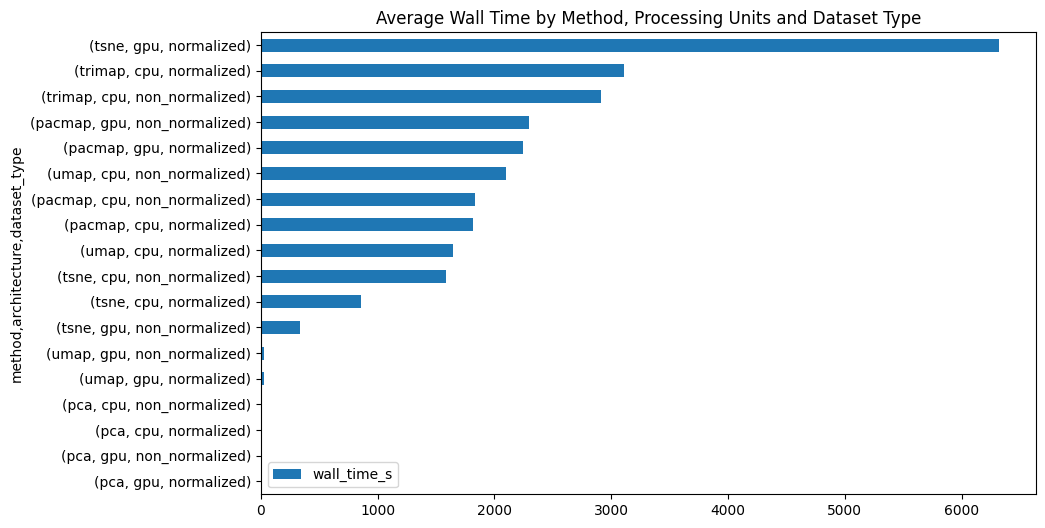

In [507]:
gr.plot(kind='barh', figsize=(10, 6), title='Average Wall Time by Method, Processing Units and Dataset Type')

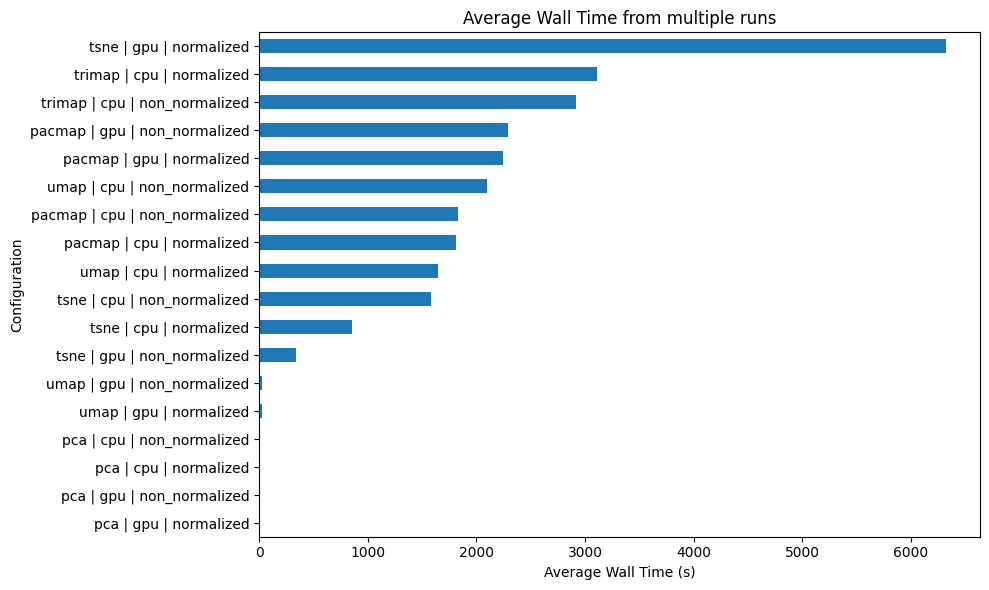

In [508]:
ax = gr['wall_time_s'].plot(kind='barh', 
                            figsize=(10, 6), 
                            title='Average Wall Time from multiple runs')

# Customize y-tick labels
# This creates labels like "pca | cpu | normalized"
new_labels = [' | '.join(map(str,idx)) for idx in gr.index]
ax.set_yticklabels(new_labels)

ax.set_xlabel("Average Wall Time (s)")
ax.set_ylabel("Configuration")

import matplotlib.pyplot as plt
plt.tight_layout()
plt.show()


Average wall_time_s by architecture:
architecture
cpu    1740.891818
gpu    1781.383125
Name: wall_time_s, dtype: float64


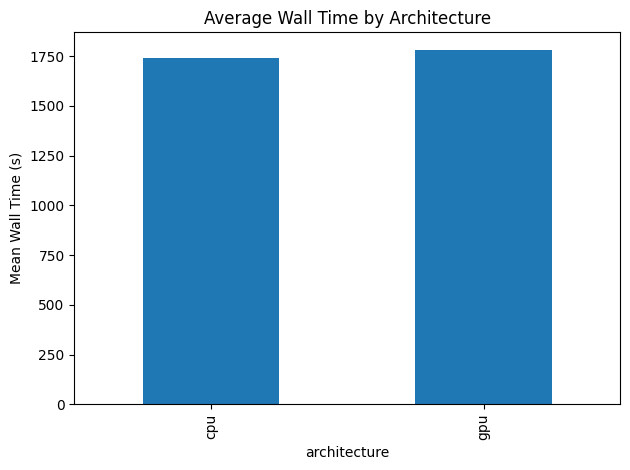


Method performance: CPU vs GPU (mean wall_time_s):
architecture       cpu          gpu
method                             
pacmap        1820.722  2260.040000
pca             11.840     1.050000
trimap        3031.184          NaN
tsne          1219.365  4824.637500
umap          1825.422    26.886667


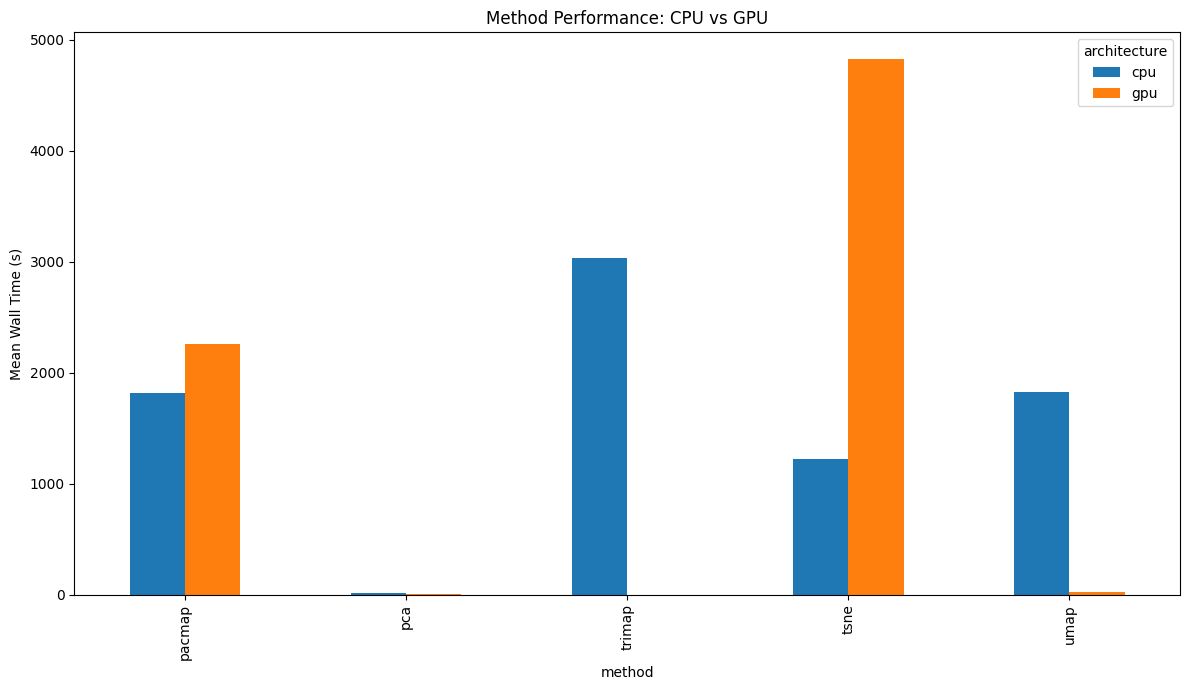

In [509]:
# filepath: c:\Users\basia\Desktop\Semestr_letni_8\LCS\projekt_2\LSC_Dimensionality_Reduction\results_analysis\results_analysis.ipynb
# ...existing code...
# Average wall time by architecture
mean_time_by_architecture = df_experiments.groupby('architecture')['wall_time_s'].mean().sort_values()
print("\nAverage wall_time_s by architecture:")
print(mean_time_by_architecture)
mean_time_by_architecture.plot(kind='bar', title='Average Wall Time by Architecture', ylabel='Mean Wall Time (s)')
plt.tight_layout()
plt.show()

# More detailed: Method performance on CPU vs GPU
method_arch_comparison = df_experiments.groupby(['method', 'architecture'])['wall_time_s'].mean().unstack()
print("\nMethod performance: CPU vs GPU (mean wall_time_s):")
print(method_arch_comparison)
method_arch_comparison.plot(kind='bar', title='Method Performance: CPU vs GPU', ylabel='Mean Wall Time (s)', figsize=(12,7))
plt.tight_layout()
plt.show()


Method performance: Normalized vs Non-normalized (mean wall_time_s):
dataset_type  non_normalized   normalized
method                                   
pacmap           1985.750000  2031.086667
pca                 8.346667     6.290000
trimap           2916.610000  3107.566667
tsne             1168.526667  4134.086000
umap              618.327143  1240.035000


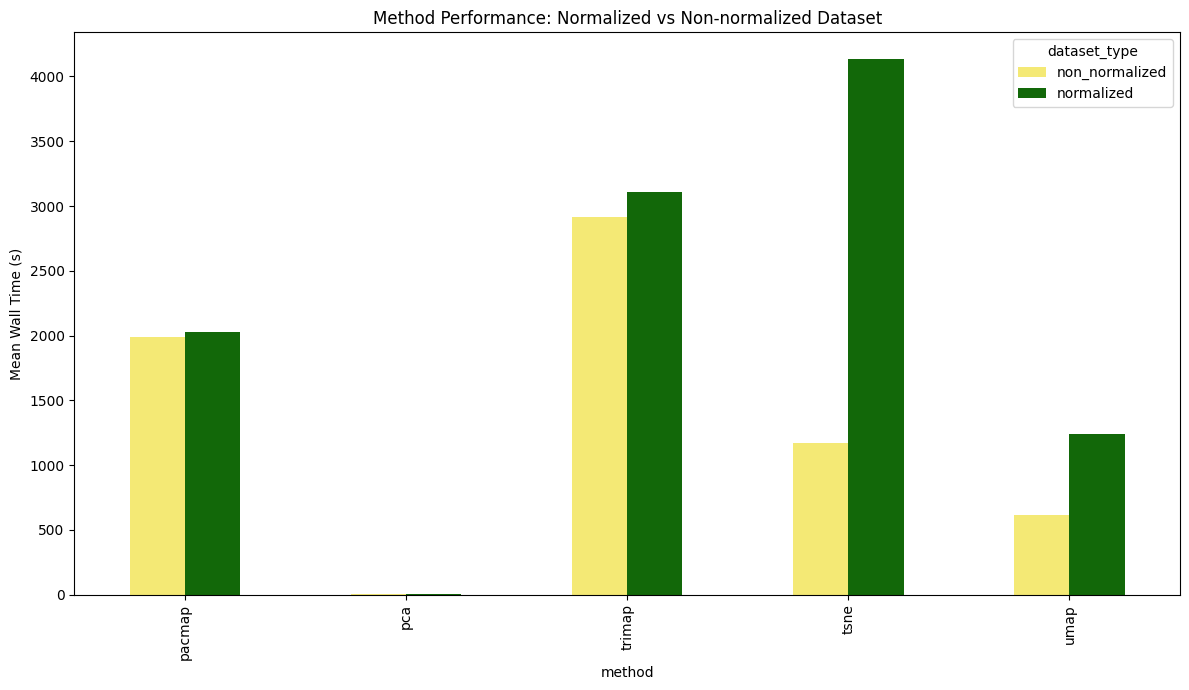

In [510]:
colors = ["#f4e975", "#126809"]
method_dataset_comparison = df_experiments.groupby(['method', 'dataset_type'])['wall_time_s'].mean().unstack()
print("\nMethod performance: Normalized vs Non-normalized (mean wall_time_s):")
print(method_dataset_comparison)
method_dataset_comparison.plot(kind='bar', title='Method Performance: Normalized vs Non-normalized Dataset', ylabel='Mean Wall Time (s)', figsize=(12,7), color=colors)
plt.tight_layout()
plt.show()


Mean CPU Total Time (s) by Method and Architecture:
architecture           cpu        gpu
method                               
pacmap         1881.392000  2340.3775
pca              42.993333     0.7750
trimap         3079.384000        NaN
tsne          11986.220000  4778.6700
umap           6694.106000        NaN


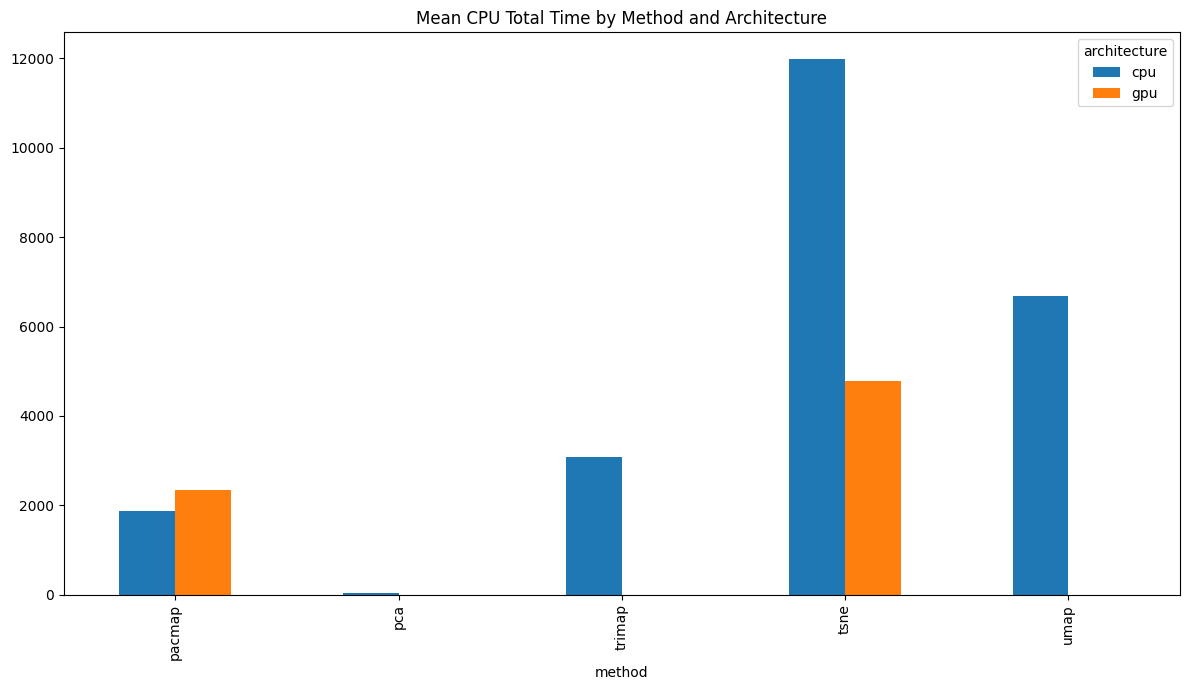


Mean GPU Kernel Time (s) by Method (for GPU runs):
method
pacmap          NaN
pca          0.7755
tsne      4824.5655
umap            NaN
Name: gpu_kernel_time_s, dtype: float64


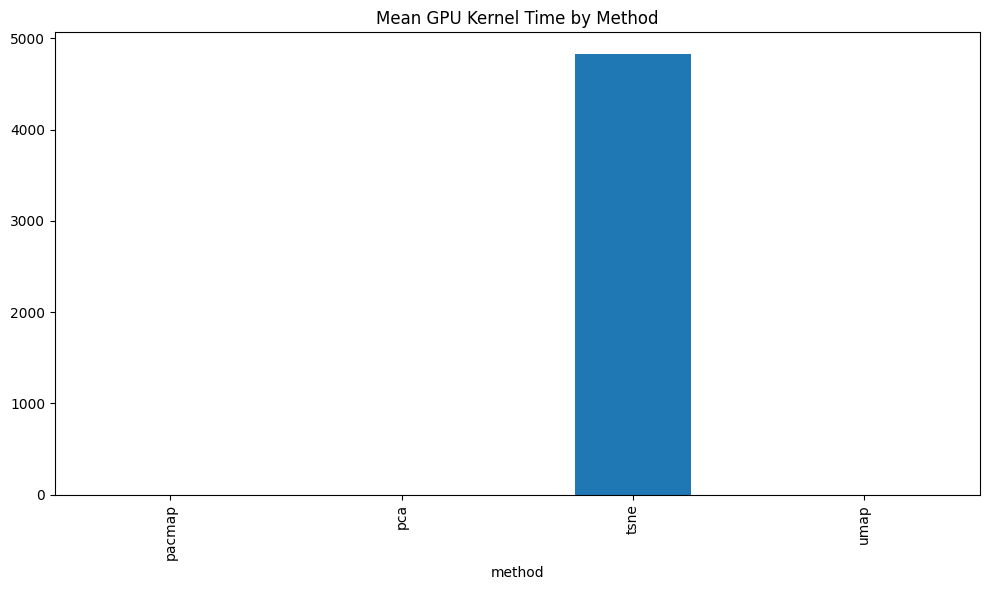

In [511]:
# filepath: c:\Users\basia\Desktop\Semestr_letni_8\LCS\projekt_2\LSC_Dimensionality_Reduction\results_analysis\results_analysis.ipynb
# ...existing code...
if 'cpu_time_total_s' in df_experiments.columns:
    cpu_time_analysis = df_experiments.groupby(['method', 'architecture'])['cpu_time_total_s'].mean().unstack()
    print("\nMean CPU Total Time (s) by Method and Architecture:")
    print(cpu_time_analysis)
    cpu_time_analysis.plot(kind='bar', title='Mean CPU Total Time by Method and Architecture', figsize=(12,7))
    plt.tight_layout()
    plt.show()

if 'gpu_kernel_time_s' in df_experiments.columns:
    gpu_kernel_time_analysis = df_experiments[df_experiments['architecture'] == 'gpu'].groupby(['method'])['gpu_kernel_time_s'].mean()
    print("\nMean GPU Kernel Time (s) by Method (for GPU runs):")
    print(gpu_kernel_time_analysis)
    if not gpu_kernel_time_analysis.empty:
        gpu_kernel_time_analysis.plot(kind='bar', title='Mean GPU Kernel Time by Method', figsize=(10,6))
        plt.tight_layout()
        plt.show()


Mean GPU Memory Used (MB) by Method (for GPU runs):
method
pacmap         NaN
pca        654.300
tsne      2590.525
umap           NaN
Name: gpu_memory_used_mb, dtype: float64


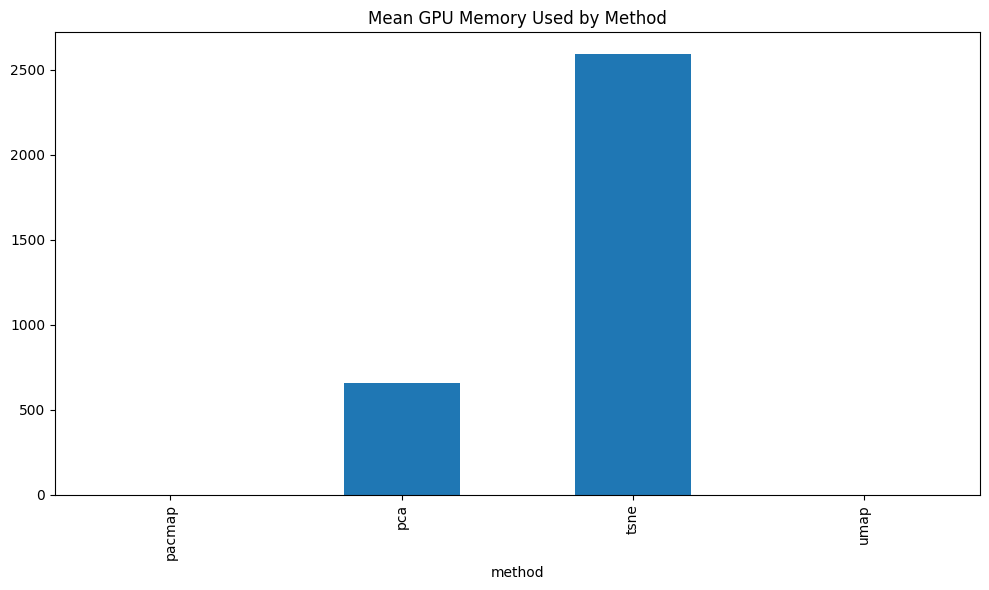

In [512]:
# filepath: c:\Users\basia\Desktop\Semestr_letni_8\LCS\projekt_2\LSC_Dimensionality_Reduction\results_analysis\results_analysis.ipynb
# ...existing code...
if 'gpu_memory_used_mb' in df_experiments.columns:
    gpu_memory_analysis = df_experiments[df_experiments['architecture'] == 'gpu'].groupby(['method'])['gpu_memory_used_mb'].mean()
    print("\nMean GPU Memory Used (MB) by Method (for GPU runs):")
    print(gpu_memory_analysis)
    if not gpu_memory_analysis.empty:
        gpu_memory_analysis.plot(kind='bar', title='Mean GPU Memory Used by Method', figsize=(10,6))
        plt.tight_layout()
        plt.show()

In [513]:
# filepath: c:\Users\basia\Desktop\Semestr_letni_8\LCS\projekt_2\LSC_Dimensionality_Reduction\results_analysis\results_analysis.ipynb
# ...existing code...
df_pca = df_experiments[df_experiments['method'] == 'pca']
if not df_pca.empty:
    print("\nPCA Specific Analysis:")
    if 'components_for_90_variance' in df_pca.columns:
        print(df_pca[['architecture', 'dataset_type', 'wall_time_s', 'components_for_90_variance']].sort_values(by='wall_time_s'))
    # Add plots or further analysis for explained variance etc.


PCA Specific Analysis:
   architecture    dataset_type  wall_time_s  components_for_90_variance
13          gpu      normalized         0.87                        61.0
12          gpu  non_normalized         1.23                        10.0
9           cpu  non_normalized        11.13                         NaN
11          cpu      normalized        11.71                        61.0
10          cpu  non_normalized        12.68                        10.0


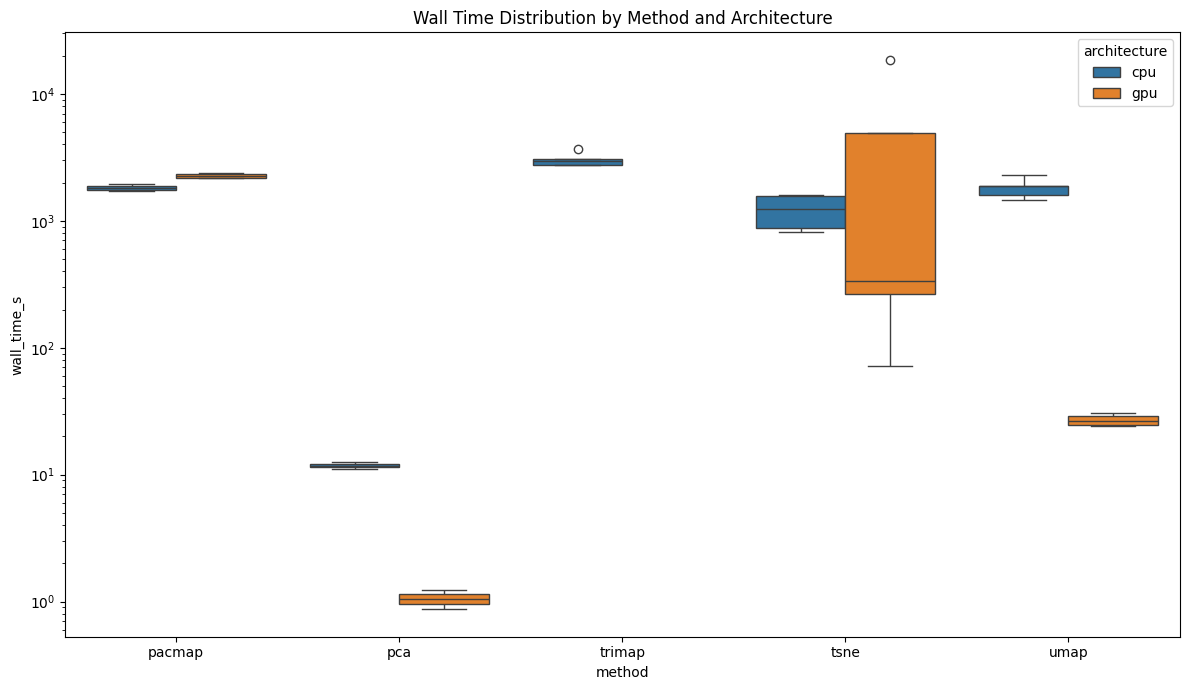

In [514]:
# ...existing code...
import seaborn as sns

# Example: Boxplot of wall_time_s by method, colored by architecture
if not df_experiments.empty:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='method', y='wall_time_s', hue='architecture', data=df_experiments)
    plt.title('Wall Time Distribution by Method and Architecture')
    plt.yscale('log') # If times vary a lot, a log scale can be helpful
    plt.tight_layout()
    plt.show()

    # Example: FacetGrid for more complex comparisons
    # g = sns.FacetGrid(df_experiments, col="dataset_type", row="architecture", margin_titles=True)
    # g.map(sns.barplot, "method", "wall_time_s", order=methods) # Assuming 'methods' is your list of methods
    # plt.tight_layout()
    # plt.show()


Method performance: Normalized vs Non-normalized (mean wall_time_s):
dataset_type  non_normalized   normalized
method                                   
pacmap           1985.750000  2031.086667
pca                 8.346667     6.290000
trimap           2916.610000  3107.566667
tsne             1168.526667  4134.086000
umap              618.327143  1240.035000


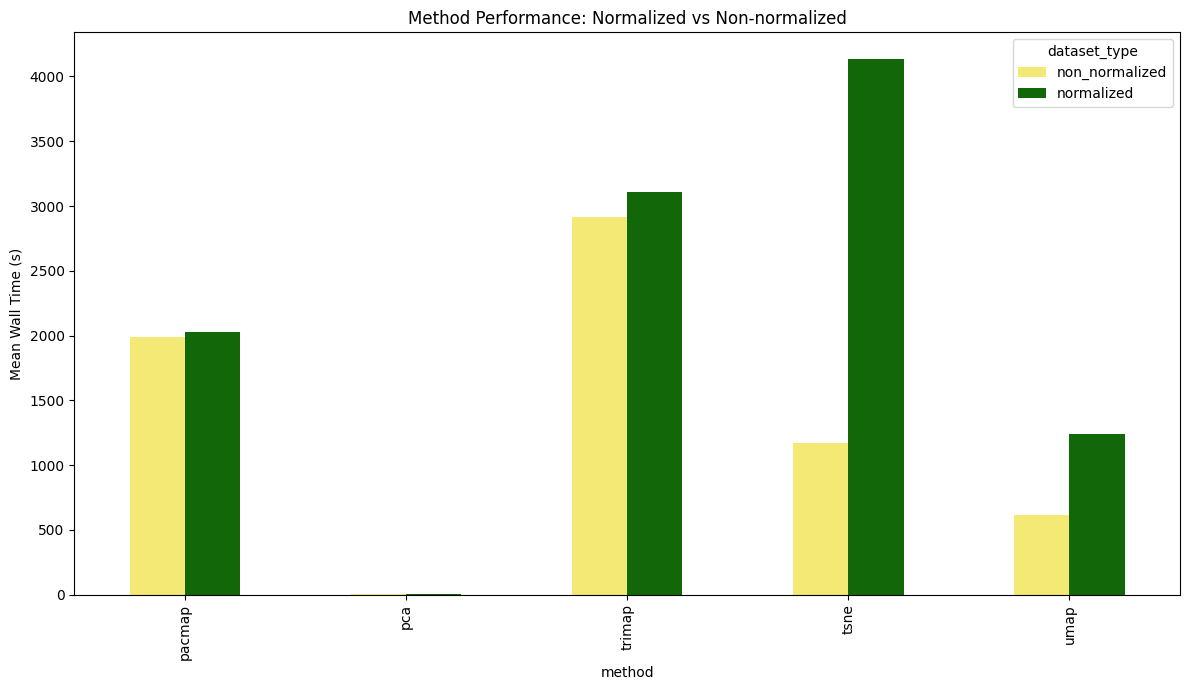

In [515]:
colors = ["#f4e975", "#126809"]
method_dataset_comparison = df_experiments.groupby(['method', 'dataset_type'])['wall_time_s'].mean().unstack()
print("\nMethod performance: Normalized vs Non-normalized (mean wall_time_s):")
print(method_dataset_comparison)
method_dataset_comparison.plot(kind='bar', title='Method Performance: Normalized vs Non-normalized', ylabel='Mean Wall Time (s)', figsize=(12,7), color=colors)
plt.tight_layout()
plt.show()

In [516]:
# filepath: c:\Users\basia\Desktop\Semestr_letni_8\LCS\projekt_2\LSC_Dimensionality_Reduction\results_analysis\results_analysis.ipynb
# ...existing code...
df_pca = df_experiments[df_experiments['method'] == 'pca']
if not df_pca.empty:
    print("\nPCA Specific Analysis:")
    if 'components_for_90_variance' in df_pca.columns:
        print(df_pca[['architecture', 'dataset_type', 'wall_time_s', 'components_for_90_variance']].sort_values(by='wall_time_s'))
    # Add plots or further analysis for explained variance etc.


PCA Specific Analysis:
   architecture    dataset_type  wall_time_s  components_for_90_variance
13          gpu      normalized         0.87                        61.0
12          gpu  non_normalized         1.23                        10.0
9           cpu  non_normalized        11.13                         NaN
11          cpu      normalized        11.71                        61.0
10          cpu  non_normalized        12.68                        10.0



Average wall_time_s by method:
method
pca          7.524000
umap       844.402727
pacmap    2015.974444
tsne      3022.001250
trimap    3031.184000
Name: wall_time_s, dtype: float64


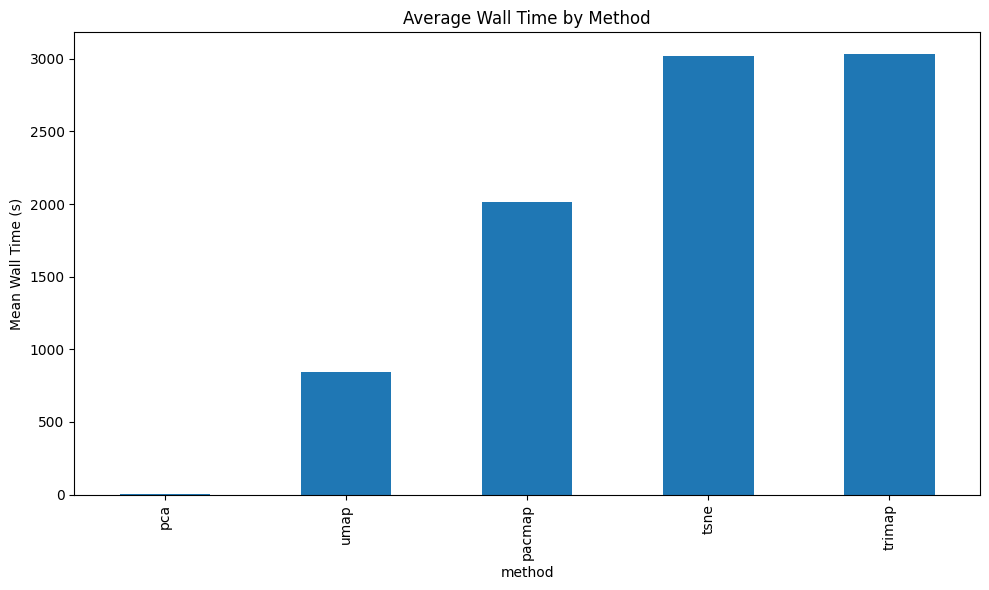

In [517]:
# filepath: c:\Users\basia\Desktop\Semestr_letni_8\LCS\projekt_2\LSC_Dimensionality_Reduction\results_analysis\results_analysis.ipynb
# ...existing code...
# Average wall time per method
mean_time_by_method = df_experiments.groupby('method')['wall_time_s'].mean().sort_values()
print("\nAverage wall_time_s by method:")
print(mean_time_by_method)
mean_time_by_method.plot(kind='bar', title='Average Wall Time by Method', ylabel='Mean Wall Time (s)', figsize=(10,6))
plt.tight_layout()
plt.show()

Overall CPU Time Statistics (s):
       cpu_time_user_s  cpu_time_sys_s  cpu_time_total_s
count        32.000000       32.000000         32.000000
mean       4192.998750       20.314062       4213.312813
std        4893.729259       26.481169       4912.081466
min           0.600000        0.050000          0.690000
25%        1407.822500        1.322500       1409.000000
50%        2406.040000        5.245000       2426.220000
75%        6239.640000       32.117500       6279.462500
max       18378.310000       83.900000      18380.230000


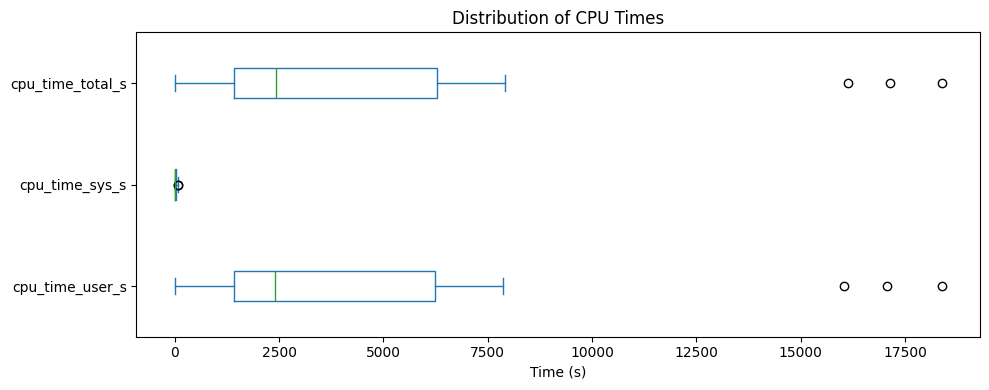

In [518]:
cpu_time_cols = ['cpu_time_user_s', 'cpu_time_sys_s', 'cpu_time_total_s']
available_cpu_cols = [col for col in cpu_time_cols if col in df_experiments.columns and df_experiments[col].notna().any()]

if available_cpu_cols:
    print("Overall CPU Time Statistics (s):")
    print(df_experiments[available_cpu_cols].describe())
    
    # Boxplot for distribution of CPU times
    if len(available_cpu_cols) > 0:
        df_experiments[available_cpu_cols].plot(kind='box', vert=False, figsize=(10, 4))
        plt.title('Distribution of CPU Times')
        plt.xlabel('Time (s)')
        plt.tight_layout()
        plt.show()


Mean Total CPU Time (s) by Method and Architecture:
architecture           cpu        gpu
method                               
pacmap         1881.392000  2340.3775
pca              42.993333     0.7750
trimap         3079.384000        NaN
tsne          11986.220000  4778.6700
umap           6694.106000        NaN


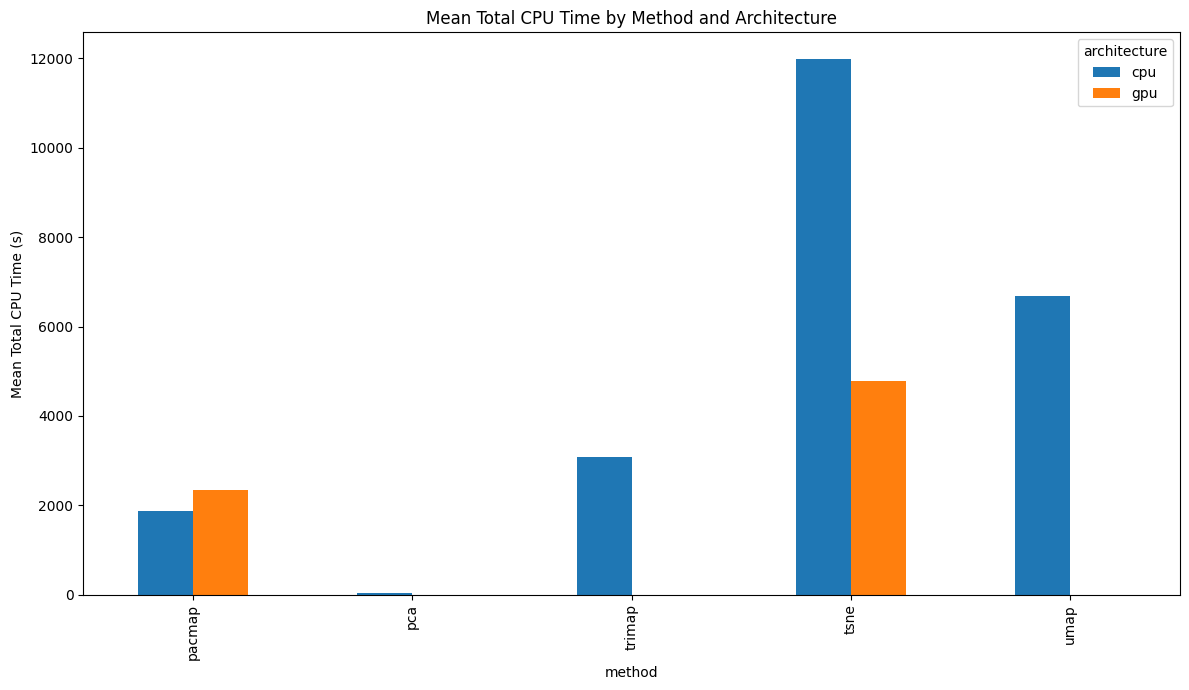


Mean User CPU Time (s) by Method and Architecture:
architecture           cpu        gpu
method                               
pacmap         1877.374000  2320.0450
pca              42.636667     0.7050
trimap         3074.678000        NaN
tsne          11914.792500  4778.0225
umap           6646.988000        NaN


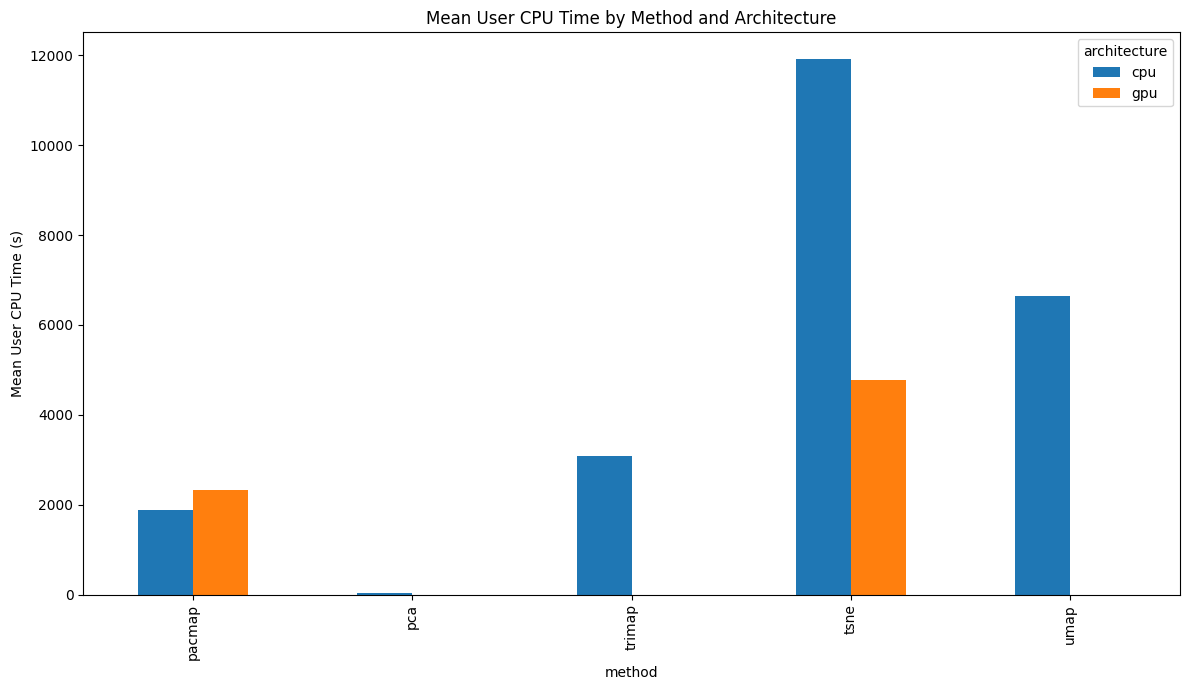


Mean System CPU Time (s) by Method and Architecture:
architecture        cpu      gpu
method                          
pacmap         4.020000  20.3300
pca            0.363333   0.0700
trimap         4.706000      NaN
tsne          71.427500   0.6475
umap          47.114000      NaN


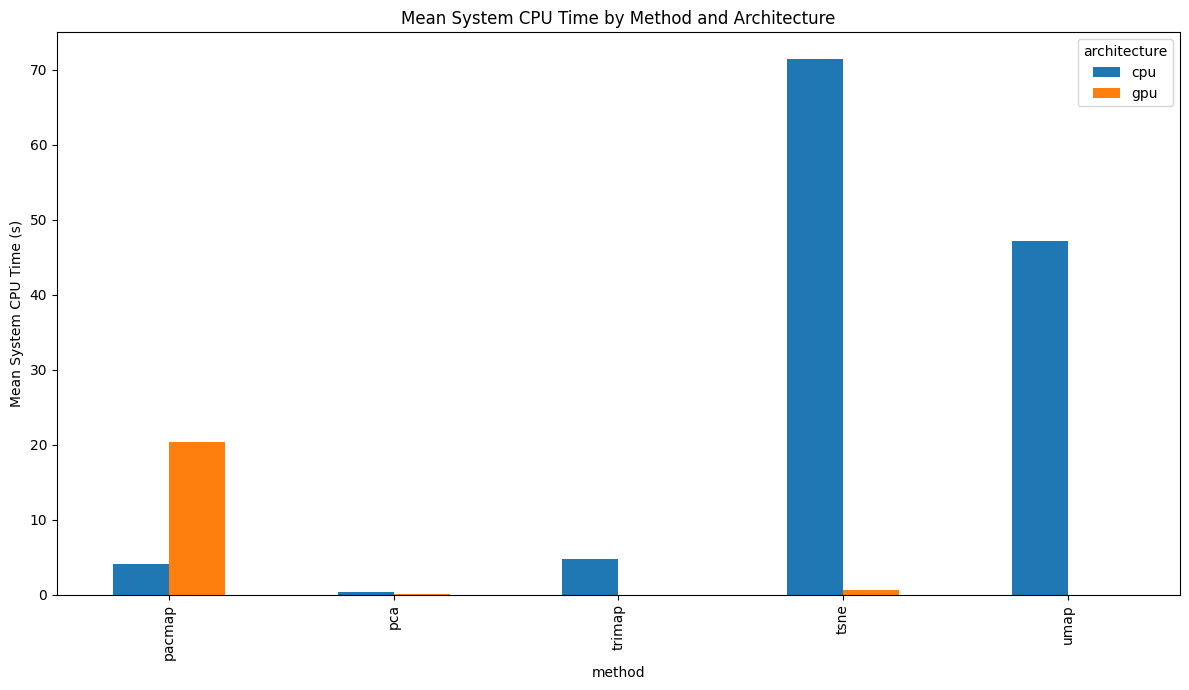

In [519]:
if 'cpu_time_total_s' in df_experiments.columns and df_experiments['cpu_time_total_s'].notna().any():
    print("\nMean Total CPU Time (s) by Method and Architecture:")
    mean_cpu_total_time = df_experiments.groupby(['method', 'architecture'])['cpu_time_total_s'].mean().unstack()
    print(mean_cpu_total_time)
    
    if not mean_cpu_total_time.empty:
        mean_cpu_total_time.plot(kind='bar', figsize=(12, 7), title='Mean Total CPU Time by Method and Architecture')
        plt.ylabel("Mean Total CPU Time (s)")
        plt.tight_layout()
        plt.show()

# You can do the same for user and system CPU times if desired
if 'cpu_time_user_s' in df_experiments.columns and df_experiments['cpu_time_user_s'].notna().any():
    print("\nMean User CPU Time (s) by Method and Architecture:")
    mean_cpu_user_time = df_experiments.groupby(['method', 'architecture'])['cpu_time_user_s'].mean().unstack()
    print(mean_cpu_user_time)
    if not mean_cpu_user_time.empty:
        mean_cpu_user_time.plot(kind='bar', figsize=(12, 7), title='Mean User CPU Time by Method and Architecture')
        plt.ylabel("Mean User CPU Time (s)")
        plt.tight_layout()
        plt.show()
else:
    print("\n'cpu_time_user_s' column not found or contains all NaNs.")

if 'cpu_time_sys_s' in df_experiments.columns and df_experiments['cpu_time_sys_s'].notna().any():
    print("\nMean System CPU Time (s) by Method and Architecture:")
    mean_cpu_sys_time = df_experiments.groupby(['method', 'architecture'])['cpu_time_sys_s'].mean().unstack()
    print(mean_cpu_sys_time)
    if not mean_cpu_sys_time.empty:
        mean_cpu_sys_time.plot(kind='bar', figsize=(12, 7), title='Mean System CPU Time by Method and Architecture')
        plt.ylabel("Mean System CPU Time (s)")
        plt.tight_layout()
        plt.show()
else:
    print("\n'cpu_time_sys_s' column not found or contains all NaNs.")



Mean CPU Time to Wall Time Ratio by Method and Architecture:
architecture       cpu       gpu
method                          
pacmap        1.033072  1.035551
pca           3.635760  0.774741
trimap        1.015417       NaN
tsne          9.534573  0.993681
umap          3.680945       NaN


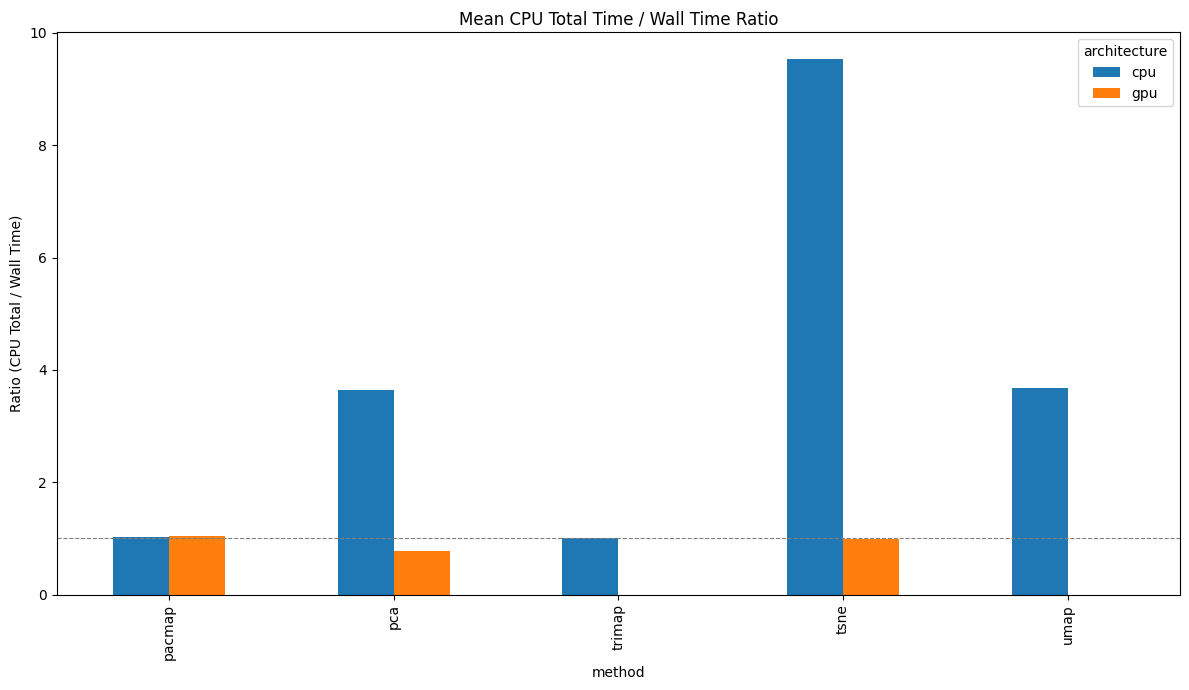

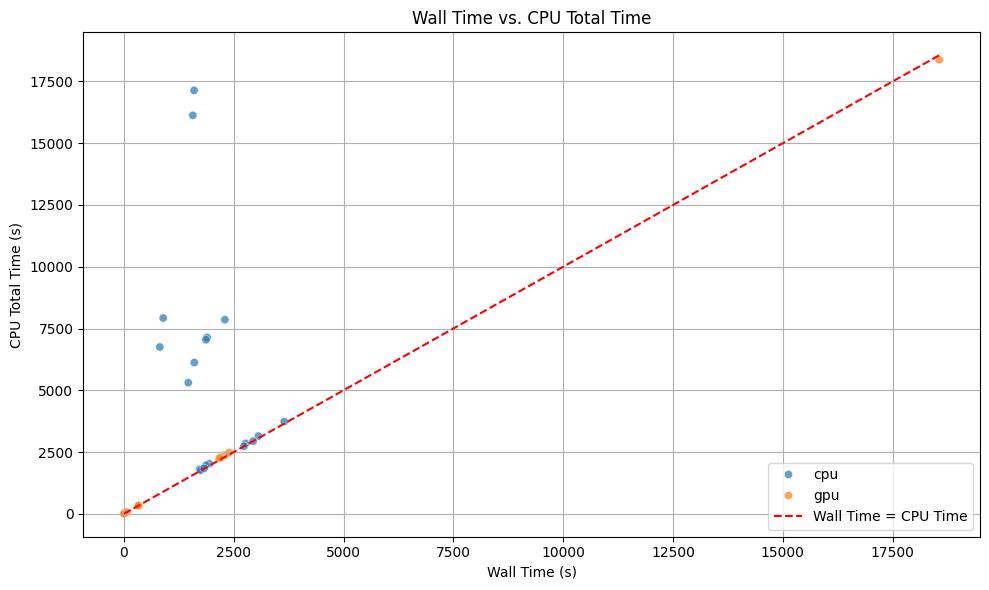

In [520]:

if 'wall_time_s' in df_experiments.columns and \
    'cpu_time_total_s' in df_experiments.columns and \
    df_experiments['wall_time_s'].notna().any() and \
    df_experiments['cpu_time_total_s'].notna().any():

    df_experiments_copy = df_experiments.copy() # Work on a copy
    df_experiments_copy['cpu_to_wall_ratio'] = df_experiments_copy['cpu_time_total_s'] / df_experiments_copy['wall_time_s']
    
    print("\nMean CPU Time to Wall Time Ratio by Method and Architecture:")
    # Filter out potential inf or NaN ratios if wall_time_s was zero or NaN
    # and cpu_time_total_s was valid.
    ratio_analysis = df_experiments_copy[df_experiments_copy['cpu_to_wall_ratio'].notna() & 
                                            np.isfinite(df_experiments_copy['cpu_to_wall_ratio'])]
    
    if not ratio_analysis.empty:
        mean_ratio = ratio_analysis.groupby(['method', 'architecture'])['cpu_to_wall_ratio'].mean().unstack()
        print(mean_ratio)
        
        if not mean_ratio.empty:
            mean_ratio.plot(kind='bar', figsize=(12,7), title='Mean CPU Total Time / Wall Time Ratio')
            plt.ylabel("Ratio (CPU Total / Wall Time)")
            plt.axhline(1, color='grey', linestyle='--', linewidth=0.8) # Add a reference line at 1
            plt.tight_layout()
            plt.show()
    else:
        print("Not enough valid data to compute CPU to Wall Time ratio analysis.")

    # Scatter plot of Wall Time vs CPU Total Time, colored by architecture
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_experiments_copy, x='wall_time_s', y='cpu_time_total_s', hue='architecture', alpha=0.7)
    # Add a y=x line for reference
    max_val = max(df_experiments_copy['wall_time_s'].max(), df_experiments_copy['cpu_time_total_s'].max())
    if pd.notna(max_val): # Check if max_val is not NaN
            plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Wall Time = CPU Time')
    plt.title('Wall Time vs. CPU Total Time')
    plt.xlabel('Wall Time (s)')
    plt.ylabel('CPU Total Time (s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\n'wall_time_s' or 'cpu_time_total_s' column not found or contains all NaNs. Cannot perform CPU vs Wall time analysis.")


In [523]:
pca_impact_analysis

precomputed_pca_flag                Without_Precomputed_PCA  \
method architecture dataset_type                              
pacmap cpu          non_normalized              1831.255000   
                    normalized                  1867.880000   
       gpu          non_normalized              2294.740000   
                    normalized                  2391.950000   
trimap cpu          non_normalized              2916.610000   
                    normalized                  3648.950000   
tsne   cpu          non_normalized              1583.315000   
                    normalized                          NaN   
       gpu          non_normalized               338.950000   
                    normalized                   326.990000   
umap   cpu          non_normalized              2096.285000   
                    normalized                  1868.190000   
       gpu          non_normalized                29.026667   
                    normalized                    25.600000   

precomputed_pca_flag                With_Precomputed_PCA  
method architecture dataset_type                          
pacmap cpu          non_normalized                   NaN  
                    normalized                  1786.610  
       gpu          non_normalized                   NaN  
                    normalized                  2176.735  
trimap cpu          non_normalized                   NaN  
                    normalized                  2836.875  
tsne   cpu          non_normalized                   NaN  
                    normalized                   855.415  
       gpu          non_normalized                   NaN  
                    normalized                  9316.305  
umap   cpu          non_normalized                   NaN  
                    normalized                  1533.175  
       gpu          non_normalized                24.320  
                    normalized                       NaN

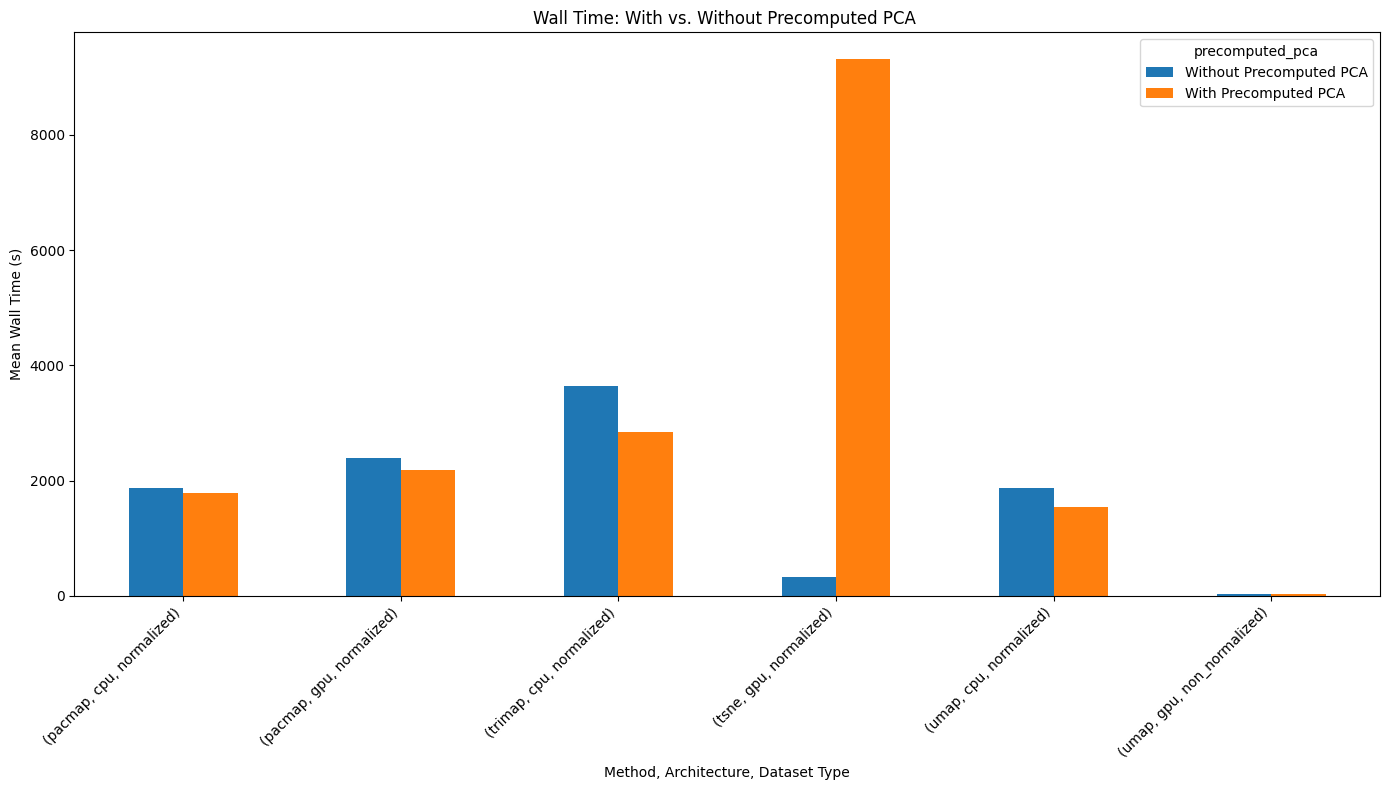

In [547]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns


non_pca_methods = df_experiments[df_experiments['method'] != 'pca'].copy()

if non_pca_methods['precomputed_pca'].nunique() > 1:
    pca_impact_analysis = non_pca_methods.groupby(
        ['method', 'architecture', 'dataset_type', 'precomputed_pca']
    )['wall_time_s'].mean().unstack(level='precomputed_pca')

    # Rename columns for clarity if they are True/False
    if True in pca_impact_analysis.columns:
        pca_impact_analysis.rename(columns={True: 'With Precomputed PCA'}, inplace=True)
    if False in pca_impact_analysis.columns:
        pca_impact_analysis.rename(columns={False: 'Without Precomputed PCA'}, inplace=True)

    valid_comparison = pca_impact_analysis.dropna(subset=['With Precomputed PCA', 'Without Precomputed PCA'])
    
    valid_comparison_copy = valid_comparison.copy()
    valid_comparison_copy['time_saved_s'] = valid_comparison_copy['Without Precomputed PCA'] - valid_comparison_copy['With Precomputed PCA']
    valid_comparison_copy['percentage_change'] = ((valid_comparison_copy['With Precomputed PCA'] - valid_comparison_copy['Without Precomputed PCA']) / valid_comparison_copy['Without Precomputed PCA']) * 100

    plot_df = valid_comparison_copy[['Without Precomputed PCA', 'With Precomputed PCA']]
    plot_df.plot(kind='bar', figsize=(14, 8),
                    title='Wall Time: With vs. Without Precomputed PCA ')
    plt.ylabel("Mean Wall Time (s)")
    plt.xlabel("Method, Architecture, Dataset Type")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [549]:
valid_comparison.sort_values(by=["With Precomputed PCA", "Without Precomputed PCA"], ascending=True)

precomputed_pca                     Without Precomputed PCA  \
method architecture dataset_type                              
umap   gpu          non_normalized                29.026667   
       cpu          normalized                  1868.190000   
pacmap cpu          normalized                  1867.880000   
       gpu          normalized                  2391.950000   
trimap cpu          normalized                  3648.950000   
tsne   gpu          normalized                   326.990000   

precomputed_pca                     With Precomputed PCA  
method architecture dataset_type                          
umap   gpu          non_normalized                24.320  
       cpu          normalized                  1533.175  
pacmap cpu          normalized                  1786.610  
       gpu          normalized                  2176.735  
trimap cpu          normalized                  2836.875  
tsne   gpu          normalized                  9316.305

In [548]:
valid_comparison_copy

precomputed_pca                     Without Precomputed PCA  \
method architecture dataset_type                              
pacmap cpu          normalized                  1867.880000   
       gpu          normalized                  2391.950000   
trimap cpu          normalized                  3648.950000   
tsne   gpu          normalized                   326.990000   
umap   cpu          normalized                  1868.190000   
       gpu          non_normalized                29.026667   

precomputed_pca                     With Precomputed PCA  time_saved_s  \
method architecture dataset_type                                         
pacmap cpu          normalized                  1786.610     81.270000   
       gpu          normalized                  2176.735    215.215000   
trimap cpu          normalized                  2836.875    812.075000   
tsne   gpu          normalized                  9316.305  -8989.315000   
umap   cpu          normalized                  1533.175    335.015000   
       gpu          non_normalized                24.320      4.706667   

precomputed_pca                     percentage_change  
method architecture dataset_type                       
pacmap cpu          normalized              -4.350922  
       gpu          normalized              -8.997471  
trimap cpu          normalized             -22.255032  
tsne   gpu          normalized            2749.110065  
umap   cpu          normalized             -17.932598  
       gpu          non_normalized         -16.214975